In [1]:
import pandas as pd 
from tabulate import tabulate
import textwrap
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk  
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [2]:
data=pd.read_csv('train_data.csv')

In [3]:
data.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive


In [4]:
data.columns

Index(['name', 'brand', 'categories', 'primaryCategories', 'reviews.date',
       'reviews.text', 'reviews.title', 'sentiment'],
      dtype='object')

In [5]:
reviews_combined = data['reviews.title'] + " " + data['reviews.text']

df = pd.DataFrame({
    'reviews': reviews_combined,
    'sentiment': data['sentiment']
})
df.head()


,reviews,sentiment
0,Powerful tablet Purchased on Black FridayPros ...,Positive
1,Amazon Echo Plus AWESOME I purchased two Amazo...,Positive
2,Average Just an average Alexa option. Does sho...,Neutral
3,Greattttttt very good product. Exactly what I ...,Positive
4,Very durable! This is the 3rd one I've purchas...,Positive


In [6]:
def wrap_text(text, width=50):
    if pd.isna(text):  
        return ""  
    return "\n".join(textwrap.wrap(text, width))

df['reviews'] = df['reviews'].apply(lambda x: wrap_text(x, width=50))

print(tabulate(df.head(2), headers='keys', tablefmt='grid', showindex=False))


+----------------------------------------------------+-------------+
| reviews                                            | sentiment   |
+====================================================+=============+
| Powerful tablet Purchased on Black FridayPros -    | Positive    |
| Great Price (even off sale)Very powerful and fast  |             |
| with quad core processors Amazing soundWell        |             |
| builtCons -Amazon ads, Amazon need this to         |             |
| subsidize the tablet and will remove the adds if   |             |
| you pay them $15.Inability to access other apps    |             |
| except the ones from Amazon. There is a way which  |             |
| I was able to accomplish to add the Google Play    |             |
| storeNet this is a great tablet for the money      |             |
+----------------------------------------------------+-------------+
| Amazon Echo Plus AWESOME I purchased two Amazon in | Positive    |
| Echo Plus and two dots plus four

In [7]:
df['sentiment'].value_counts()

sentiment
Positive    3749
Neutral      158
Negative      93
Name: count, dtype: int64

C:\Users\datapro\AppData\Local\Temp\ipykernel_18224\3563328097.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='viridis')


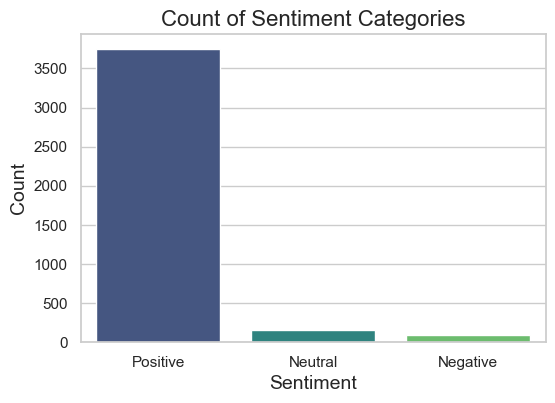

In [9]:
sns.set(style='whitegrid')

plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df, palette='viridis')

plt.title('Count of Sentiment Categories', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.show()

In [10]:
df.describe()

,reviews,sentiment
count,4000,4000
unique,3595,3
top,,Positive
freq,10,3749


In [11]:
df.isnull().sum()

reviews      0
sentiment    0
dtype: int64

In [12]:
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\datapro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\datapro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
def preprocess_text(text):
    if pd.isna(text):  
        return ""
    
    text = text.lower()
    
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    tokens = text.split()
    
    tokens = [word for word in tokens if word not in stop_words]
    
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

In [14]:
df['cleaned_reviews'] = df['reviews'].apply(preprocess_text)
print(df[['reviews', 'cleaned_reviews']].head())

                                             reviews  \
0  Powerful tablet Purchased on Black FridayPros ...   
1  Amazon Echo Plus AWESOME I purchased two Amazo...   
2  Average Just an average Alexa option. Does sho...   
3  Greattttttt very good product. Exactly what I\...   
4  Very durable! This is the 3rd one I've purchas...   

                                     cleaned_reviews  
0  powerful tablet purchased black fridaypros gre...  
1  amazon echo plus awesome purchased two amazon ...  
2  average average alexa option show thing screen...  
3  greattttttt good product exactly wanted good p...  
4  durable rd one ive purchased ive bought one ni...  


In [15]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_reviews'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
print(tfidf_df.head())


   abc  ability      able  absent  absolute  absolutely  absorbs  abuse   ac  \
0  0.0      0.0  0.104407     0.0       0.0         0.0      0.0    0.0  0.0   
1  0.0      0.0  0.000000     0.0       0.0         0.0      0.0    0.0  0.0   
2  0.0      0.0  0.000000     0.0       0.0         0.0      0.0    0.0  0.0   
3  0.0      0.0  0.000000     0.0       0.0         0.0      0.0    0.0  0.0   
4  0.0      0.0  0.000000     0.0       0.0         0.0      0.0    0.0  0.0   

   accelerometer  ...  youth  youtube  youve   yr  zero  zigbee  zinio  zippy  \
0            0.0  ...    0.0      0.0    0.0  0.0   0.0     0.0    0.0    0.0   
1            0.0  ...    0.0      0.0    0.0  0.0   0.0     0.0    0.0    0.0   
2            0.0  ...    0.0      0.0    0.0  0.0   0.0     0.0    0.0    0.0   
3            0.0  ...    0.0      0.0    0.0  0.0   0.0     0.0    0.0    0.0   
4            0.0  ...    0.0      0.0    0.0  0.0   0.0     0.0    0.0    0.0   

   zone  zoom  
0   0.0   0.0  


In [16]:
#joblib.dump(tfidf_matrix, 'tfidf_matrix.joblib')
#joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')

print("TF-IDF matrix and vectorizer saved successfully.")

TF-IDF matrix and vectorizer saved successfully.


In [17]:
label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df['sentiment'] = df['sentiment'].map(label_mapping)

In [18]:
tfidf_vectorizer = joblib.load('tfidf_vectorizer.joblib')

tfidf_matrix = tfidf_vectorizer.transform(df['cleaned_reviews'])

c:\Users\datapro\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.4.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\datapro\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.4.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [19]:
X = tfidf_matrix
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#EXISTING SYSTEM


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import joblib

# # Splitting the dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_mapping.keys())) 

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy Score: {accuracy:.2f}")

#joblib.dump(model, 'logistic_regression_model.joblib')

conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")


Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.08      0.14        13
     Neutral       1.00      0.08      0.15        36
    Positive       0.94      1.00      0.97       751

    accuracy                           0.94       800
   macro avg       0.98      0.39      0.42       800
weighted avg       0.95      0.94      0.92       800

Test Accuracy Score: 0.94
Confusion Matrix:
[[  1   0  12]
 [  0   3  33]
 [  0   0 751]]


#Proposed System--XGB accuracy improvement

In [22]:
import xgboost as xgb


In [23]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')


In [24]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

c:\Users\datapro\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:09:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [25]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_mapping.keys()))

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.54      0.70        13
     Neutral       0.73      0.22      0.34        36
    Positive       0.96      1.00      0.98       751

    accuracy                           0.95       800
   macro avg       0.90      0.59      0.67       800
weighted avg       0.95      0.95      0.94       800



In [26]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy Score: {accuracy:.2f}")

Test Accuracy Score: 0.95


In [52]:
joblib.dump(model,'Xgboost.joblib') 

['Xgboost.joblib']

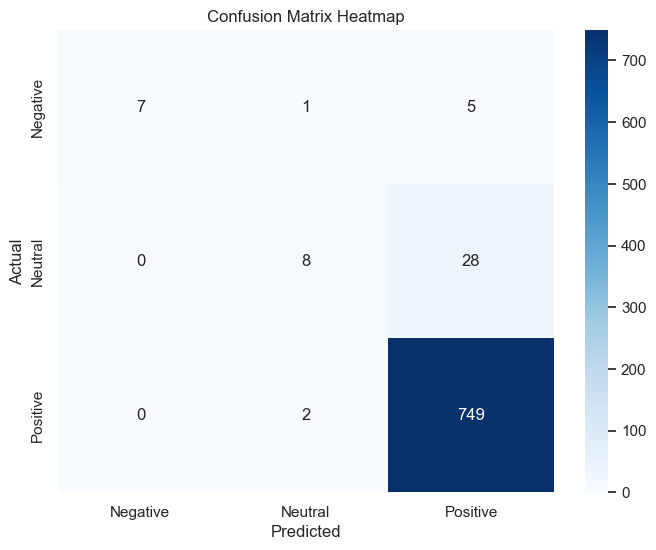

In [27]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [33]:
from sklearn.ensemble import RandomForestClassifier # type: ignore

# Define the Random Forest model
model_rf = RandomForestClassifier(random_state=42, criterion='entropy')

# Additional settings
# random_state: Ensures reproducibility
# criterion: Use 'gini' (default) or 'entropy' for impurity measure
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

In [34]:
print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=label_mapping.keys()))

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.54      0.70        13
     Neutral       1.00      0.17      0.29        36
    Positive       0.95      1.00      0.98       751

    accuracy                           0.95       800
   macro avg       0.98      0.57      0.65       800
weighted avg       0.96      0.95      0.94       800



In [41]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Test Accuracy Score: {accuracy:.2f}")

Test Accuracy Score: 0.95


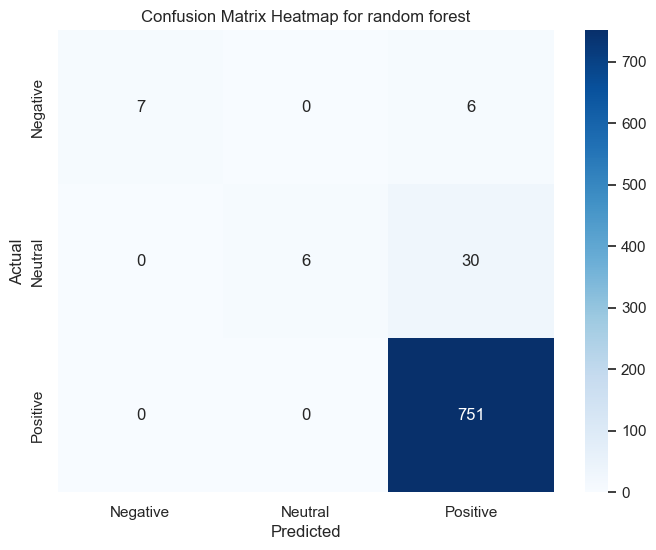

In [37]:
conf_matrix = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title('Confusion Matrix Heatmap for random forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [38]:
xgb_cm = confusion_matrix(y_test, y_pred)
rf_cm = confusion_matrix(y_test, y_pred_rf)

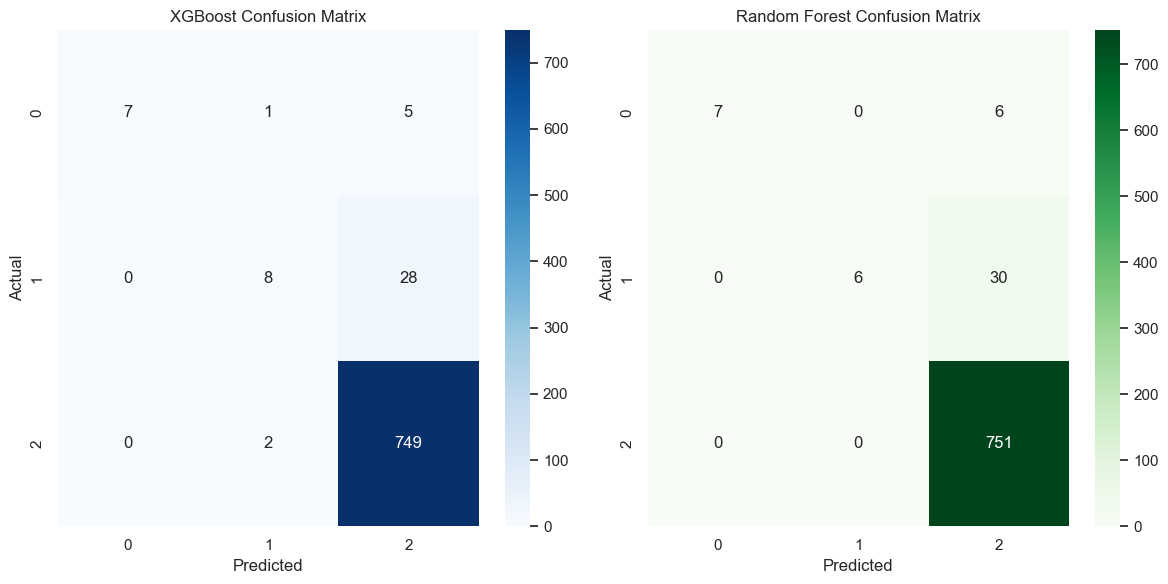

In [39]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("XGBoost Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("Random Forest Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

In [43]:
# Compare Accuracy
print("\nComparison of Models:")
print(f"XGBoost Accuracy: {accuracy:.4f}")
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

if accuracy > accuracy_rf:
    print("XGBoost performs better.")
elif accuracy_rf > accuracy:
    print("Random Forest performs better.")
else:
    print("Both models perform equally well.")


Comparison of Models:
XGBoost Accuracy: 0.9550
Random Forest Accuracy: 0.9550
Both models perform equally well.


In [28]:
import gradio as gr
import joblib
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

model = joblib.load('Xgboost.joblib')  
tfidf_vectorizer = joblib.load('tfidf_vectorizer.joblib')

analyzer = SentimentIntensityAnalyzer()

def predict_sentiment(text):
    
    predicted_probability= analyzer.polarity_scores(text)['compound']
    xgb_predictions = "Positive" if predicted_probability > 0 else "Negative" if predicted_probability < 0 else "Neutral"

    
    cleaned_text = text.lower()  
    tfidf_features = tfidf_vectorizer.transform([cleaned_text])

    
    xgb_prediction = model.predict(tfidf_features)[0]
    sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    xgb_sentiment = sentiment_mapping[xgb_prediction]

    return {
        ('predicted_probability score',predicted_probability, xgb_predictions),
    }

iface = gr.Interface(
    fn=predict_sentiment,
    inputs="text",
    outputs='text',
    title="Sentiment Analysis on E-Commerce Reviews",
    description="Enter a text to get sentiment .................!."
)

iface.launch()


c:\Users\datapro\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:09:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\data\../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)
c:\Users\datapro\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.4.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
